In [1]:
import gridmap_config as c
polygons = c.kenya_counties_msSimplified

In [2]:
import os
import geopandas as gp
import matplotlib.pyplot as plt
from IPython.display import Markdown, display, HTML
from pandas import DataFrame
from tabulate import tabulate
from shapely import geometry, wkt
import pandas as pd

In [3]:
os.path.isfile(polygons)

True

In [4]:
counties = gp.read_file(polygons).to_crs({'init': 'epsg:32662'})
num_features = counties.shape[0]

counties['Country'] = 'Kenya'
country = counties.dissolve(by='Country').to_crs({'init': 'epsg:32662'})

tbl_data = [['Fields']]
for fld in list(counties):
        tbl_data.append([fld])
        
display(HTML(tabulate(tbl_data, headers="firstrow", tablefmt='html', stralign='left')))

Fields
County
CID
CountyID
AreaSQKM
Shape_Leng
Shape_Area
Pop_Sumcou
Pop_Sumsum
area
avg_area


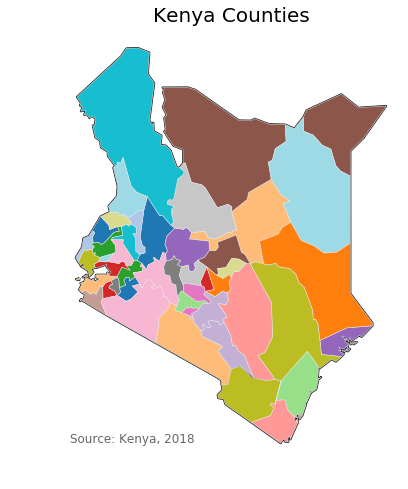

In [5]:
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.axis('off')
ax.set_title('Kenya Counties', fontdict={'fontsize': '20', 'fontweight' : '500'})
ax.annotate('Source: Kenya, 2018',
            xy=(0.17, .115),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='0.4')

country.plot(color='white', ax=ax, linewidth=2, edgecolor='0.1')
counties.plot(column='County', cmap='tab20', ax=ax, linewidth=0.5, edgecolor='0.9')
plt.show()

In [6]:
def round_coords_dict(coords, r):
    for key, coord in coords.items():
        coords[key] = float(round(coords[key], r))
    return coords

def get_bounding_coordinates(feature, r=c.round_to, round_nums=True):
    coords = feature.bounds 
    bbox = {}
    bbox['min_x'] = coords['minx'].min()
    bbox['min_y'] = coords['miny'].min()
    bbox['max_x'] = coords['maxx'].max()
    bbox['max_y'] = coords['maxy'].max()
    bbox['range_x'] = bbox['max_x'] - bbox['min_x']
    bbox['range_y'] = bbox['max_y'] - bbox['min_y']
    
    if round_nums:
        bbox = round_coords_dict(bbox, r)
    
    return bbox

map_extent = get_bounding_coordinates(counties)    

print(map_extent)

{'min_x': 3778640.71291, 'min_y': -520530.68101, 'max_x': 4665640.10698, 'max_y': 608975.26912, 'range_x': 886999.39407, 'range_y': 1129505.95012}


Square size: 94361.63767
<class 'geopandas.geodataframe.GeoDataFrame'>


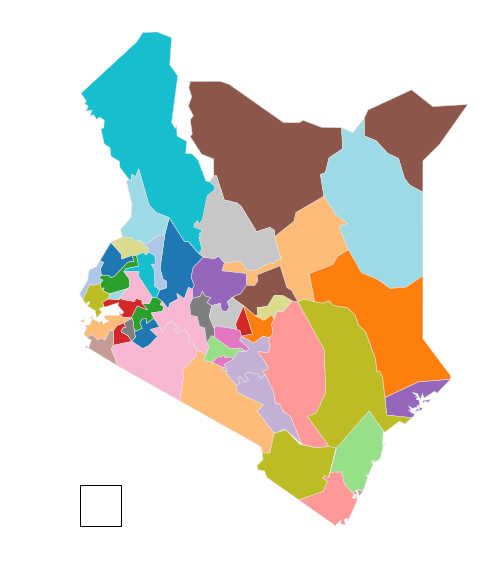

In [7]:
square_size = round(min(map_extent['range_x'], map_extent['range_y'])/(num_features/5), c.round_to)
print('Square size: {}'.format(square_size))

def seed_box(bb, size, corner='lowerleft'):
    if corner == 'lowerleft':
        LL = [bb['min_x'], bb['min_y']]               #lower left corner
        LR = [bb['min_x'] + size, bb['min_y']]        #lower right corner
        UR = [bb['min_x'] + size, bb['min_y'] + size] #upper right corner
        UL = [bb['min_x'], bb['min_y'] + size]        #upper left corner
    
    if corner == 'lowerright':
        LL = [bb['max_x'] - size, bb['min_y']]        #lower left corner
        LR = [bb['max_x'], bb['min_y']]               #lower right corner
        UR = [bb['max_x'], bb['min_y'] + size] #upper right corner
        UL = [bb['max_x'] - size, bb['min_y'] + size] #upper left corner
        
    if corner == 'upperright':
        LL = [bb['max_x'] - size, bb['max_y'] - size] #lower left corner
        LR = [bb['max_x'], bb['max_y'] - size]        #lower right corner
        UR = [bb['max_x'], bb['max_y']]               #upper right corner
        UL = [bb['max_x'] - size, bb['max_y']]        #upper left corner 
        
    if corner == 'upperleft':
        LL = [bb['min_x'], bb['max_y'] - size]        #lower left corner
        LR = [bb['min_x'] + size, bb['max_y'] - size] #lower right corner
        UR = [bb['min_x'] + size, bb['max_y']]        #upper right corner
        UL = [bb['min_x'], bb['max_y']]               #upper left corner
    
    to_poly = geometry.Polygon([LL, LR, UR, UL])
    box_coords = pd.DataFrame({'Vertices': [to_poly]})
    box = gp.GeoDataFrame(box_coords, geometry='Vertices')
    
    return box

seed = seed_box(bb=map_extent, size=square_size, corner='lowerleft')
tiles = seed
print(type(tiles))

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
counties.plot(column='County', cmap='tab20', ax=ax, linewidth=0.5, edgecolor='0.9')
seed.plot(ax=ax, facecolor="none", edgecolor='black')

plt.show()
        

In [16]:
def grow_boxes(seed_box, size=square_size, corner='lowerleft'):
    bb = get_bounding_coordinates(seed_box, round_nums=False) 

    if corner == 'lowerleft':
        LL = [bb['max_x'], bb['min_y']]               #lower left corner
        LR = [bb['max_x'] + size, bb['min_y']]        #lower right corner
        UR = [bb['max_x'] + size, bb['min_y'] + size] #upper right corner
        UL = [bb['max_x'], bb['min_y'] + size]        #upper left corner

    to_poly = geometry.Polygon([LL, LR, UR, UL])
    box_coords = pd.DataFrame({'Vertices': [to_poly]})
    box = gp.GeoDataFrame(box_coords, geometry='Vertices')

    return box, bb


box2, bounds = grow_boxes(seed)
box3, bounds = grow_boxes(box2)
print(type(seed))
print(seed.shape)

tiles = gp.GeoDataFrame(columns=seed.columns)

def append_box(new_box, outdf):
    for idx, row in new_box.items():
        print(type(row))
        outdf = outdf.append(row, ignore_index=True)
    return outdf
            
tiles = append_box(box2, tiles)
print(type(tiles))
print(tiles.shape)
print(tiles.head())
"""
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
counties.plot(column='County', cmap='tab20', ax=ax, linewidth=0.5, edgecolor='0.9')
tiles.plot(ax=ax, facecolor="none", edgecolor='black')

plt.show()
"""

<class 'geopandas.geodataframe.GeoDataFrame'>
(1, 1)
<class 'geopandas.geoseries.GeoSeries'>
<class 'geopandas.geodataframe.GeoDataFrame'>
(1, 2)
  Vertices                                                  0
0      NaN  POLYGON ((3873002.35058 -520530.68101, 3967363...


'\nfig, ax = plt.subplots(1, figsize=(10, 10))\nax.axis(\'off\')\ncounties.plot(column=\'County\', cmap=\'tab20\', ax=ax, linewidth=0.5, edgecolor=\'0.9\')\ntiles.plot(ax=ax, facecolor="none", edgecolor=\'black\')\n\nplt.show()\n'